# Step 0:

- mounted drive
- loaded csv file

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import random
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from typing import Iterator, List, Callable, Tuple
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/BitdefenderFmiAssignments/Assignment1/pmi-data.csv'

In [ ]:
df = pd.read_csv(path)
df.describe()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000
mean,2523.911666,36785.750701,1.394279,48.853898,0.125070,0.063937,0.759955,3.424846,0.491307,108.982011,30.243326,1.309310,0.056646
std,1490.463154,21239.999608,0.489337,18.874375,0.330845,0.244675,0.427170,0.894640,0.499995,48.292204,7.155000,0.810144,0.231198
min,0.000000,67.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000
25%,1221.750000,18042.750000,1.000000,34.000000,0.000000,0.000000,1.000000,3.000000,0.000000,77.460000,25.400000,1.000000,0.000000
50%,2518.500000,37448.500000,1.000000,50.000000,0.000000,0.000000,1.000000,4.000000,0.000000,92.650000,29.100000,2.000000,0.000000
75%,3819.500000,54984.250000,2.000000,63.000000,0.000000,0.000000,1.000000,4.000000,1.000000,116.677500,33.800000,2.000000,0.000000
max,5108.000000,72915.000000,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,92.000000,2.000000,1.000000


# Step 2 (Datasets and Dataloaders):
- split data between train, test, validation

- 20% of the dataset for validation

- data is shuffled by default

- dataset & dataset loader

In [ ]:
x=np.array(df.drop('stroke',axis=1))
y=np.array(df['stroke'])

n_samples, n_features = x.shape
input_size = n_features
output_size = 1

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=10)

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print('Samples in Train Set:', len(X_train))
print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))
print('Pacients without stroke(0) vs with stroke(1):')
print(df['stroke'].value_counts())

Samples in Train Set: 2674
Samples in Validation Set: 713
Samples in Test Set: 179
Pacients without stroke(0) vs with stroke(1):
0    3364
1     202
Name: stroke, dtype: int64


# Step 3 (Model):
- class inherits nn.Module
- overwrote init and forward functions
- used sequence of linear and relu layers


In [ ]:
class StrokeModel(nn.Module):
    def __init__(self):
        super(StrokeModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu(x)
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = StrokeModel().to(device)
print(model)
#for param in model. parameters ():
#  print(param)

Using cuda device
StrokeModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


# Step 4 (Optimizer and Loss function):
- BCEWithLogitsLoss as loss function
- Adam as optimizer

In [ ]:
model=StrokeModel()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([.06]))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
print(model)

StrokeModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


# Step 5: Training and Evaluation
- iterate through dataset
- use gpu
- print loss value and accuracy


In [ ]:
num_epochs = 500
max_acc = -1
for epoch in range(num_epochs):
    # Reset gradients
    optimizer.zero_grad()

    # Forward + loss
    y_predicted = model(X_train)
    train_loss = criterion(y_predicted, y_train)
    with torch.no_grad():
      y_predicted_cls = (torch.sigmoid(y_predicted) > 0.5).float()
      #print(y_predicted_cls)
      #print(y_train)
      acc = y_predicted_cls.eq(y_train).sum() / float(y_train.shape[0])
      if acc > max_acc:
          max_acc = acc

    # Backward + param update
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_predicted = model(X_val)
        validation_loss = criterion(y_predicted, y_val)

    if (epoch + 1) % 50 == 0:
        print(f'epoch: {epoch + 1}, train loss = {train_loss.item():.4f}, validation loss = {validation_loss.item():.4f}, accuracy = {acc:.4f}')

print(f'Max accuracy = {max_acc:.4f}')

epoch: 50, train loss = 0.0411, validation loss = 0.0413, accuracy = 0.9473
epoch: 100, train loss = 0.0042, validation loss = 0.0044, accuracy = 0.9697
epoch: 150, train loss = 0.0034, validation loss = 0.0038, accuracy = 0.9787
epoch: 200, train loss = 0.0032, validation loss = 0.0036, accuracy = 0.9806
epoch: 250, train loss = 0.0029, validation loss = 0.0033, accuracy = 0.9809
epoch: 300, train loss = 0.0028, validation loss = 0.0032, accuracy = 0.9817
epoch: 350, train loss = 0.0028, validation loss = 0.0032, accuracy = 0.9824
epoch: 400, train loss = 0.0027, validation loss = 0.0032, accuracy = 0.9828
epoch: 450, train loss = 0.0027, validation loss = 0.0032, accuracy = 0.9839
epoch: 500, train loss = 0.0027, validation loss = 0.0032, accuracy = 0.9839
Max accuracy = 0.9929


# Step 6: Balancing the training data

- print confusion matrix

accuracy: 0.9721
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Prediction: 0.0, Actual values: 0.0
Precision:  0.9851190476190477  Recall:  0.84375  fscore:  0.8998545373167729


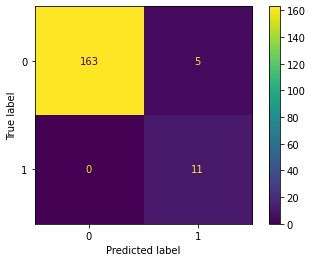

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = (torch.sigmoid(y_predicted) > 0.5).float()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc:.4f}')

    for i in range(10):
        r = random.randint(1, y_test.shape[0])
        print(f'Prediction: {y_predicted_cls[r].item()}, Actual values: {y_test[r].item()}')

    precision, recall, F1, _ = precision_recall_fscore_support(y_test, y_predicted_cls, average='macro')
    print('Precision: ', precision, ' Recall: ', recall, ' fscore: ', F1)
    conf_matrix = confusion_matrix(y_predicted_cls, y_test)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show